In [12]:
!rm -rf graph-pes-results/custom-model-run*
!rm -rf custom_model.py
!rm -rf config.yaml

In [2]:
%%writefile custom_model.py

from __future__ import annotations

import torch
from graph_pes import AtomicGraph, GraphPESModel
from graph_pes.atomic_graph import (
    PropertyKey,
    index_over_neighbours,
    neighbour_distances,
    sum_over_neighbours,
)
from graph_pes.models.components.distances import Bessel, PolynomialEnvelope
from graph_pes.utils.nn import MLP, PerElementEmbedding


class CustomModel(GraphPESModel):
    def __init__(
        self,
        cutoff: float,
        channels: int,
        radial_features: int,
    ):
        super().__init__(
            cutoff,
            implemented_properties=["local_energies"],
        )

        # node embeddings
        self.Z_embedding = PerElementEmbedding(channels)

        # messages
        self.radial_basis = Bessel(radial_features, cutoff)
        self.envelope = PolynomialEnvelope(cutoff)
        self.message = MLP(
            layers=[
                radial_features + channels,
                2 * channels,
                2 * channels,
                channels,
            ],
            activation="CELU",
            bias=False,
        )

        # readout
        self.readout = MLP(
            layers=[channels, channels, 1],
            activation="CELU",
        )

    def forward(self, graph: AtomicGraph) -> dict[PropertyKey, torch.Tensor]:
        # compute the local energies
        # assume that the input graph has N atoms, E edges
        # and denote the number of radial features as R
        # and the number of channels as C

        # 1. embed node features
        h = self.Z_embedding(graph.Z)  # (N, C)

        # 2. expand distances
        r = neighbour_distances(graph)  # (E,)
        r_features = self.radial_basis(r)  # (E, R)
        r_features = self.envelope(r_features)  # (E, R)

        # 3. create neigbour embeddings
        h_neighbour = index_over_neighbours(h, graph)  # (E, C)
        neighbour_embeddings = torch.cat(
            [h_neighbour, r_features], dim=-1
        )  # (E, C + R)

        # 4. create messages
        messages = self.message(neighbour_embeddings)  # (E, C)

        # 5. aggregate messages
        aggregated_messages = sum_over_neighbours(messages, graph)  # (N, C)

        # 6. update node embeddings
        h = h + aggregated_messages  # (N, C)

        # 7. readout
        local_energies = self.readout(h).squeeze(-1)  # (N,)

        return {"local_energies": local_energies}

Writing custom_model.py


We can now use and instantiate our model as normal:

In [3]:
from ase.build import molecule
from custom_model import CustomModel
from graph_pes import AtomicGraph

model = CustomModel(cutoff=5.0, channels=3, radial_features=8)
graph = AtomicGraph.from_ase(molecule("H2O"))
model(graph)

{'local_energies': tensor([-0.3244, -0.3394, -0.3394], grad_fn=<SqueezeBackward1>)}

In [4]:
model.get_all_PES_predictions(graph)

{'energy': tensor(-1.0031, grad_fn=<SumBackward1>),
 'forces': tensor([[-0.0000e+00, -2.7285e-12,  5.3379e-05],
         [-0.0000e+00,  3.1064e-05, -2.6689e-05],
         [-0.0000e+00, -3.1064e-05, -2.6689e-05]], grad_fn=<NegBackward0>),
 'local_energies': tensor([-0.3244, -0.3394, -0.3394], grad_fn=<SqueezeBackward1>)}

In [5]:
from ase.io import write
from load_atoms import load_dataset

dataset = load_dataset("QM7")
train, val, test = dataset.random_split([1000, 100, 500])
write("train.xyz", train)
write("val.xyz", val)

Output()

Our configuration file is as normal:

In [6]:
%%writefile config.yaml

model:
    custom_model.CustomModel:
        cutoff: 5.0
        channels: 3
        radial_features: 8

data:
    train:
        graph_pes.data.file_dataset:
            path: train.xyz
            cutoff: 5.0
    valid:
        graph_pes.data.file_dataset:
            path: val.xyz
            cutoff: 5.0

loss: graph_pes.training.loss.PerAtomEnergyLoss()

fitting:
    trainer_kwargs:
        max_epochs: 150
        accelerator: cpu
        check_val_every_n_epoch: 5

    optimizer:
        graph_pes.training.opt.Optimizer:
            name: AdamW
            lr: 0.001
    
    loader_kwargs:
        batch_size: 64

general:
    run_id: custom-model-run
    progress: logged

wandb: null


Writing config.yaml


In [7]:
%%bash

export GRAPH_PES_ALLOW_IMPORT=custom_model
graph-pes-train config.yaml

[graph-pes INFO]: Set logging level to INFO
[graph-pes INFO]: Started training at 2024-10-30 10:31:14.183
[graph-pes INFO]: Output directory: graph-pes-results/custom-model-run
[graph-pes INFO]: Logging using <pytorch_lightning.loggers.csv_logs.CSVLogger object at 0x16d10ddf0>


[graph-pes INFO]: Logging to graph-pes-results/custom-model-run/logs/rank-0.log
[graph-pes INFO]: 
model:
   custom_model.CustomModel:
      cutoff: 5.0
      channels: 3
      radial_features: 8
data:
   train:
      graph_pes.data.file_dataset:
         path: train.xyz
         cutoff: 5.0
   valid:
      graph_pes.data.file_dataset:
         path: val.xyz
         cutoff: 5.0
loss: graph_pes.training.loss.PerAtomEnergyLoss()
fitting:
   pre_fit_model: true
   max_n_pre_fit: 5000
   early_stopping_patience: null
   trainer_kwargs:
      max_epochs: 150
      accelerator: cpu
      enable_model_summary: false
      check_val_every_n_epoch: 5
   loader_kwargs:
      num_workers: 0
      persistent_workers: false
      batch_size: 64
      pin_memory: false
   optimizer:
      graph_pes.training.opt.Optimizer:
         name: AdamW
         lr: 0.001
   scheduler: null
   swa: null
general:
   seed: 42
   root_dir: graph-pes-results
   run_id: custom-model-run
   log_level: INFO
   progr

[graph-pes INFO]: Setting up datasets
[graph-pes INFO]: Pre-fitting the model on 1,000 samples
[graph-pes INFO]: 
Model:
CustomModel(
  (Z_embedding): PerElementEmbedding(
    dim=3,
    elements=['H', 'C', 'N', 'O', 'S']
  )
  (radial_basis): Bessel(n_features=8, cutoff=5.0, trainable=True)
  (envelope): PolynomialEnvelope(cutoff=5.0, p=6)
  (message): MLP(11 → 6 → 6 → 3, activation=CELU(alpha=1.0))
  (readout): MLP(3 → 3 → 1, activation=CELU(alpha=1.0))
)

[graph-pes INFO]: Number of learnable params : 159


                            valid/metrics   timer/its_per_s   timer/its_per_s
   epoch      time   per_atom_energy_rmse             train             valid
       4       0.8                0.75332         200.00000         291.66669
       9       1.6                0.69501         142.85715         291.66669
      14       2.3                0.62171         166.66667         291.66669
      19       3.1                0.49764         200.00000         291.66669
      24       3.8                0.31937         166.66667         416.66669
      29       4.6                0.22743         166.66667         291.66669
      34       5.3                0.21521         200.00000         291.66669
      39       6.0                0.18348         166.66667         291.66669
      44       6.8                0.16561         166.66667         291.66669
      49       7.5                0.15000         166.66667         375.00000
      54       8.3                0.14105         166.66667     

Analysis
--------

We can now load our trained model and analyse the results:

In [10]:
from graph_pes.models import load_model

model = load_model("graph-pes-results/custom-model-run/model.pt")
model

CustomModel(
  (Z_embedding): PerElementEmbedding(
    dim=3,
    elements=['H', 'C', 'N', 'O', 'S']
  )
  (radial_basis): Bessel(n_features=8, cutoff=5.0, trainable=True)
  (envelope): PolynomialEnvelope(cutoff=5.0, p=6)
  (message): MLP(11 → 6 → 6 → 3, activation=CELU(alpha=1.0))
  (readout): MLP(3 → 3 → 1, activation=CELU(alpha=1.0))
)

This is a very unsophisticated architecture, so we don't expect it to be particularly accurate...:

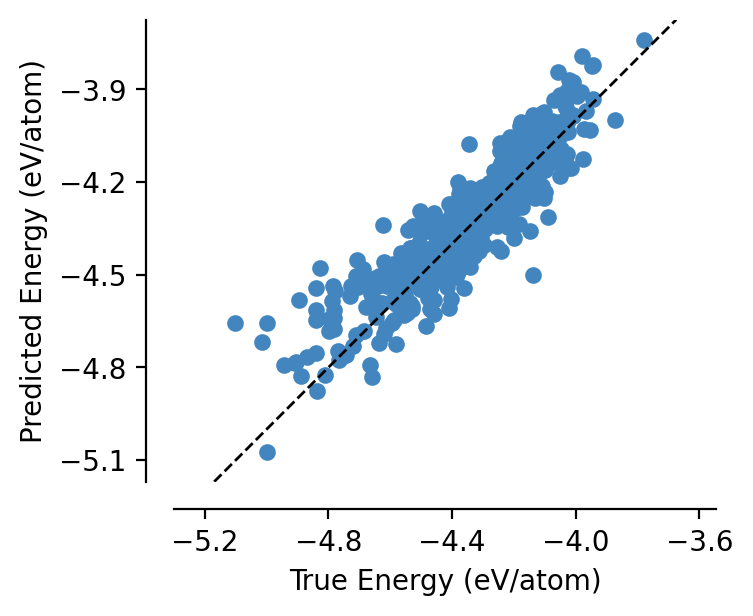

In [11]:
from graph_pes.atomic_graph import divide_per_atom
from graph_pes.utils.analysis import parity_plot

%config InlineBackend.figure_format = 'retina'

test_graphs = [AtomicGraph.from_ase(s, cutoff=model.cutoff.item()) for s in test]
parity_plot(
    model,
    test_graphs,
    property="energy",
    transform=divide_per_atom,
    units="eV/atom",
)